# Animal Shelter Pt. 2 - Adoption Rate Prediction
- In Part 1, the dependent variable was "Outcome Type", meaning the model predicts whether an animal will face a positive (adopted, returned to owner, transfer) or negative (euthanize, dead, disposed, stolen) outcome.


- In this section, the dependent variable is "days in shelter"
    - How long will an animal stay at the shelter?
    - How can the shelter increase a given animal's appeal to increase adoption rate?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import seaborn as sns
from scipy import stats
from pylab import savefig

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from collections import Counter

plt.style.use('ggplot')

import warnings
warnings.filterwarnings("ignore")

#show all columns
pd.set_option('display.max_columns', None)

In [2]:
#import csv into a pandas dataframe
df = pd.read_csv('../data/Animal_Shelter_Intake_and_Outcome.csv')

In [3]:
#how much of the data are NaN's?
df.isna().sum()/len(df)

Name                    0.256197
Type                    0.000000
Breed                   0.000000
Color                   0.000000
Sex                     0.000000
Size                    0.001552
Date Of Birth           0.241324
Impound Number          0.000000
Kennel Number           0.000401
Animal ID               0.000000
Intake Date             0.000000
Outcome Date            0.004407
Days in Shelter         0.000000
Intake Type             0.000000
Intake Subtype          0.000000
Outcome Type            0.004657
Outcome Subtype         0.014272
Intake Condition        0.000000
Outcome Condition       0.015674
Intake Jurisdiction     0.000000
Outcome Jurisdiction    0.139516
Outcome Zip Code        0.141069
Location                0.141069
Count                   0.000000
dtype: float64

Outcome Type
ADOPTION           6326
DIED                135
DISPOSAL            125
ESCAPED/STOLEN       17
EUTHANIZE          2779
RETURN TO OWNER    6711
RTOS                 11
TRANSFER           3772
Name: Animal ID, dtype: int64

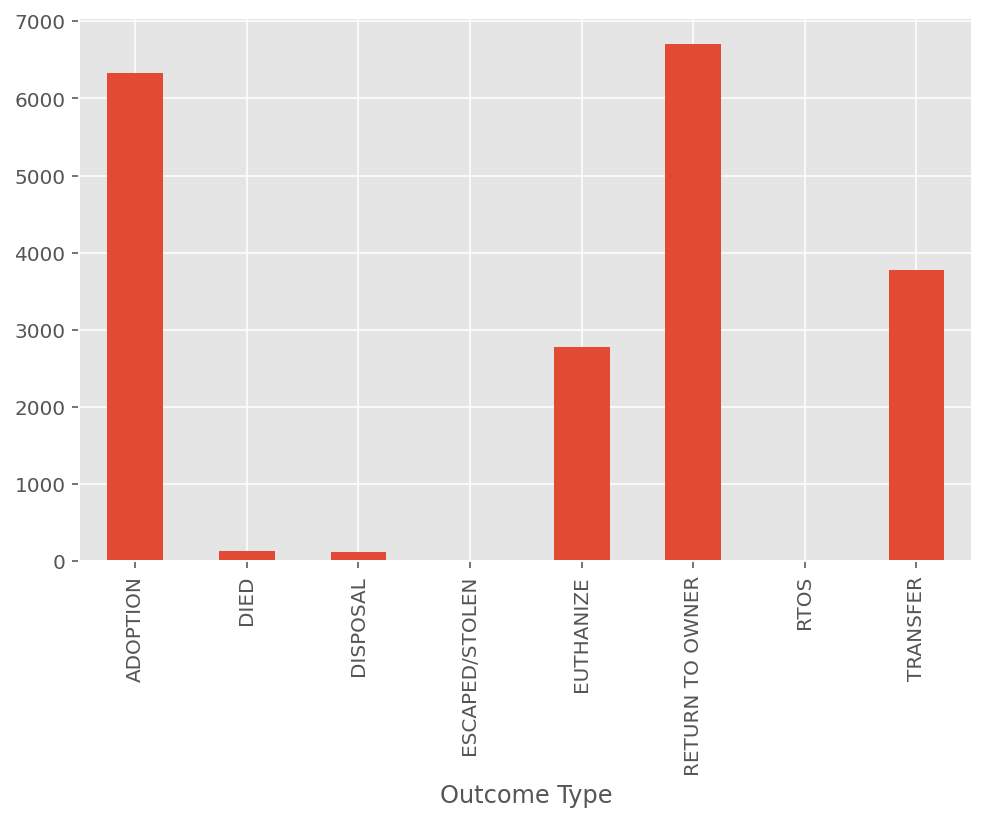

In [4]:
df.groupby('Outcome Type').count()['Animal ID'].plot(kind='bar', figsize=(8,5))
df.groupby('Outcome Type').count()['Animal ID']

In [5]:
#datetime_type = year, month, dayofweek, or hour
def parse_date_cols(df, col: str, new_col: str, datetime_type: str):
    df[col] = pd.to_datetime(df[col])
    if datetime_type == 'year':
        df[new_col] = df[col].dt.year
    elif datetime_type == 'month':
        df[new_col] = df[col].dt.month
    elif datetime_type == 'dayofweek':
        df[new_col] = df[col].dt.dayofweek
    elif datetime_type == 'hour':
        df[new_col] = df[col].dt.hour
    else:
        print("wrong datetime type")
    return df

#convert col values dtype: int, float, string, etc
def convert_dtype(df, col: str, new_dtype: str):
    df[col] = df[col].astype(new_dtype)
    return df

#convert dtype in columns
parse_date_cols(df, 'Outcome Date', '_', '_')
parse_date_cols(df, 'Date Of Birth', '_', '_')
convert_dtype(df, 'Days in Shelter', 'int')

#Create month, dayofweek, year columns from intake date
parse_date_cols(df, 'Intake Date', 'Intake_Month', datetime_type='month')
parse_date_cols(df, 'Intake Date', 'Intake_dayofweek', datetime_type='dayofweek')
parse_date_cols(df, 'Intake Date', 'Intake_Year', datetime_type='year')

# Parse 'Outcome Date' for EDA, not for modeling - potential data leakage
parse_date_cols(df, 'Outcome Date', 'Outcome_Month', datetime_type='month')
parse_date_cols(df, 'Outcome Date', 'Outcome_dayofweek', datetime_type='dayofweek')
parse_date_cols(df, 'Outcome Date', 'Outcome_Year', datetime_type='year')

wrong datetime type
wrong datetime type


,Name,Type,Breed,Color,Sex,Size,Date Of Birth,Impound Number,Kennel Number,Animal ID,Intake Date,Outcome Date,Days in Shelter,Intake Type,Intake Subtype,Outcome Type,Outcome Subtype,Intake Condition,Outcome Condition,Intake Jurisdiction,Outcome Jurisdiction,Outcome Zip Code,Location,Count,Intake_Month,Intake_dayofweek,Intake_Year,Outcome_Month,Outcome_dayofweek,Outcome_Year
0,SKY,DOG,GERM SHEPHERD,BLACK/TAN,Female,MED,NaT,K20-035118,DS69,A395686,2020-01-19,2020-01-23,4,STRAY,FIELD,RETURN TO OWNER,OVER THE COUNTER_CALL,HEALTHY,HEALTHY,COUNTY,COUNTY,95404.0,"95404(38.458384, -122.675588)",1,1,6,2020,1.0,3.0,2020.0
1,COCO,DOG,BEAGLE,TRICOLOR,Neutered,SMALL,2015-04-06,K17-025093,DS83,A379968,2017-08-30,2017-10-04,35,STRAY,FIELD,TRANSFER,NC AN FRND,UNKNOWN,HEALTHY,SANTA ROSA,OUT OF COUNTY,95758.0,"95758(38.424655, -121.438065)",1,8,2,2017,10.0,2.0,2017.0
2,SUZIE,DOG,LABRADOR RETR/MIX,BLACK,Spayed,LARGE,2011-01-23,K15-012348,DA34,A315553,2015-01-07,2015-01-24,17,STRAY,OVER THE COUNTER,ADOPTION,INTERNET,HEALTHY,HEALTHY,SANTA ROSA,SANTA ROSA,95404.0,"95404(38.458384, -122.675588)",1,1,2,2015,1.0,5.0,2015.0
3,NaN,DOG,GERM SHEPHERD/MIX,TRICOLOR,Unknown,MED,NaT,K20-036188,VET,A398868,2020-07-12,2020-07-12,0,CONFISCATE,FLD_CRUEL,RETURN TO OWNER,MEDICAL,UNKNOWN,HEALTHY,SANTA ROSA,NaN,NaN,NaN,1,7,6,2020,7.0,6.0,2020.0
4,FELIX,CAT,DOMESTIC SH,BLACK,Neutered,KITTN,2018-05-12,K18-029084,LOBBY,A374683,2018-07-12,2018-08-04,23,STRAY,OVER THE COUNTER,ADOPTION,WALKIN,HEALTHY,HEALTHY,SANTA ROSA,COUNTY,95407.0,"95407(38.403734, -122.736775)",1,7,3,2018,8.0,5.0,2018.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19964,*ONYX,CAT,DOMESTIC SH,BLACK,Neutered,SMALL,2011-02-23,K16-017789,CS04,A333091,2016-02-13,2016-03-18,34,STRAY,OVER THE COUNTER,ADOPTION,WALKIN,HEALTHY,HEALTHY,SANTA ROSA,COUNTY,95403.0,"95403(38.486997, -122.749134)",1,2,5,2016,3.0,4.0,2016.0
19965,NaN,DOG,CHIHUAHUA SH,TAN,Female,TOY,NaT,K15-013157,DS91,A317956,2015-03-14,2015-04-23,40,STRAY,OVER THE COUNTER,EUTHANIZE,AGGRESSIVE,TREATABLE/REHAB,UNTREATABLE,SANTA ROSA,NaN,NaN,NaN,1,3,5,2015,4.0,3.0,2015.0
19966,TEDDY BEAR,DOG,BICHON FRISE/MIX,CREAM,Neutered,SMALL,2011-06-15,K18-028664,DA20,A374057,2018-06-15,2018-06-15,0,STRAY,FIELD,RETURN TO OWNER,OVER THE COUNTER_WEB,UNKNOWN,HEALTHY,SANTA ROSA,SANTA ROSA,95403.0,"95403(38.486997, -122.749134)",1,6,4,2018,6.0,4.0,2018.0
19967,TIPPY,CAT,DOMESTIC SH,BLACK/WHITE,Spayed,SMALL,2009-10-13,K17-025618,CA03,A362428,2017-10-09,2017-11-05,27,STRAY,FIELD,RETURN TO OWNER,OVER THE COUNTER_PRVS,UNKNOWN,HEALTHY,SANTA ROSA,COUNTY,95403.0,"95403(38.486997, -122.749134)",1,10,0,2017,11.0,6.0,2017.0


In [6]:
# Create "Age" column that subtracts the pet's date of birth from the intake date
# choose method: median, mean, or 0 --> to replace NaN's
def create_fill_age_col(df, method='median'):
    df['Age'] = df['Intake Date'] - df['Date Of Birth']
    df['Age'] = df['Age'].dt.days.astype(float)
    
    if method == 'median':
        df['Age'] = df['Age'].fillna(df['Age'].median())
    
    elif method == 'mean':
        df['Age'] = df['Age'].fillna(df['Age'].mean())
    
    elif method == '0':
        df['Age'] = df['Age'].fillna(0)
        
    #convert from age in Days to Years
    df['Age'] = round(df['Age'] / 365, 2)
    
    #drop DoB col
    df = df.drop(columns='Date Of Birth', inplace=True)
        
    return df

create_fill_age_col(df)

### Simplify column values for: Sex, Outcome Type, and Size
- Like the previous classification model, the outcome type is being seperated into "good" (alive) or "bad" (dead) outcomes
    - Speculations, may need to adjust:
        - May need to isolate "Adoption" to its own class by creating a "neutral" class that includes: Return to owner (RTOS), and Transfer
        - Size column may not need to be simplified - it might be useful to have "kittn" and "puppy" as their own class
        - Sex column shows Male, Female, Neutered, and Spayed -- this MAY play a role in adoption rates, need to speculate

### To separate animal type (Cat, Dog, Other) and run the model for each? Or all together?
- Probably will need to try both and see which yields a better accuracy score

In [7]:
def simplify_col_vals(df, col:str, value:list, replacement:list):
    # spayed --> female, neutered --> male, unknown remains as is
    df[col] = df[col].replace(value, replacement*len(value))

# Simplify 'Sex' column from 5 unique vals into 3 - Male, Female, Unknown
def replace_simplify_group_cols(df):
    
    # Create new column 'Fixed' that shows True if an animal is neutered or spayed
    df['Fixed'] = df['Sex'].apply(lambda x: True if x in ['Neutered', 'Spayed'] else False)
    
    # Create new column 'Has_Name' that shows True if an animal has a name
    df['Has_Name'] = df['Name'].notnull()
    
    # Have 'Sex' column only show male or female
    simplify_col_vals(df, 'Sex', ['Neutered'], ['Male'])
    simplify_col_vals(df, 'Sex', ['Spayed'], ['Female'])

    # Simplify 'Outcome Type' --> "good", "neutral", "bad"
    outcome_adopt = ['ADOPTION']
    outcome_return = ['RETURN TO OWNER', 'RTOS']
    outcome_transfer = ['TRANSFER'] 
    outcome_bad = ['DIED', 'DISPOSAL', 'EUTHANIZE', 'ESCAPED/STOLEN']

    #drop 93 rows with missing 'Outcome Type'
    df = df[df['Outcome Type'].notna()]
    simplify_col_vals(df, 'Outcome Type', outcome_bad, [0])
    simplify_col_vals(df, 'Outcome Type', outcome_transfer, [1])
    simplify_col_vals(df, 'Outcome Type', outcome_return, [2])
    simplify_col_vals(df, 'Outcome Type', outcome_adopt, [3])
    # dtype of this column is object -- might need to change to int later
    
    # Consolidate redundant cat breeds 
    simplify_col_vals(df, 'Breed', ['LH DOMESTIC'], ['DOMESTIC LH'])
    simplify_col_vals(df, 'Breed', ['MH DOMESTIC'], ['DOMESTIC MH'])
    simplify_col_vals(df, 'Breed', ['SH DOMESTIC'], ['DOMESTIC SH'])
    
#     #simplify 'Size' column
#     smol = ['KITTN', 'PUPPY', 'TOY']
#     simplify_col_vals(df, 'Size', smol, ['SMALL'])
    
    return df

df = replace_simplify_group_cols(df)

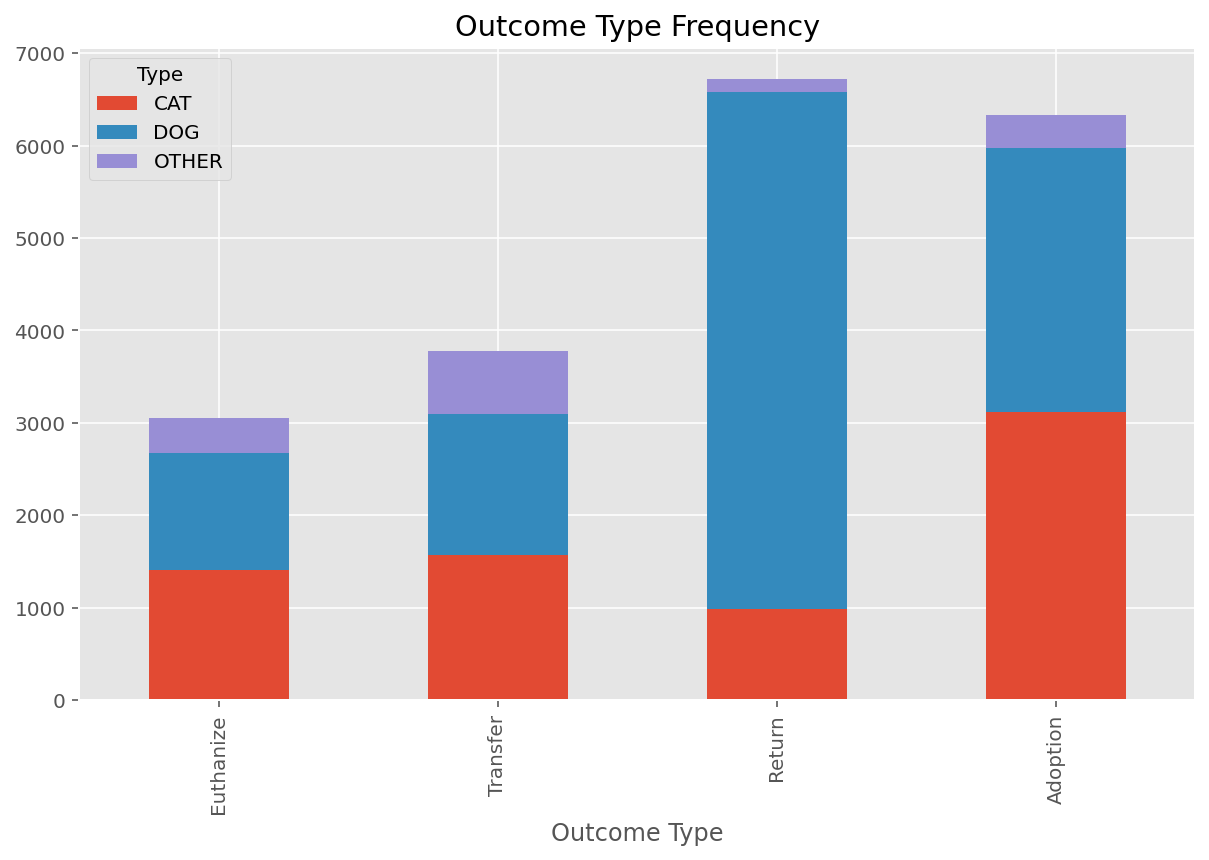

In [16]:
fig, ax = plt.subplots()
df.groupby(['Outcome Type','Type']).size().unstack().plot(kind='bar',stacked=True, title="Outcome Type Frequency", figsize=(10,6),
                                                            ax=ax)
ax.set_xticklabels(["Euthanize", "Transfer", "Return", "Adoption"])
plt.show()

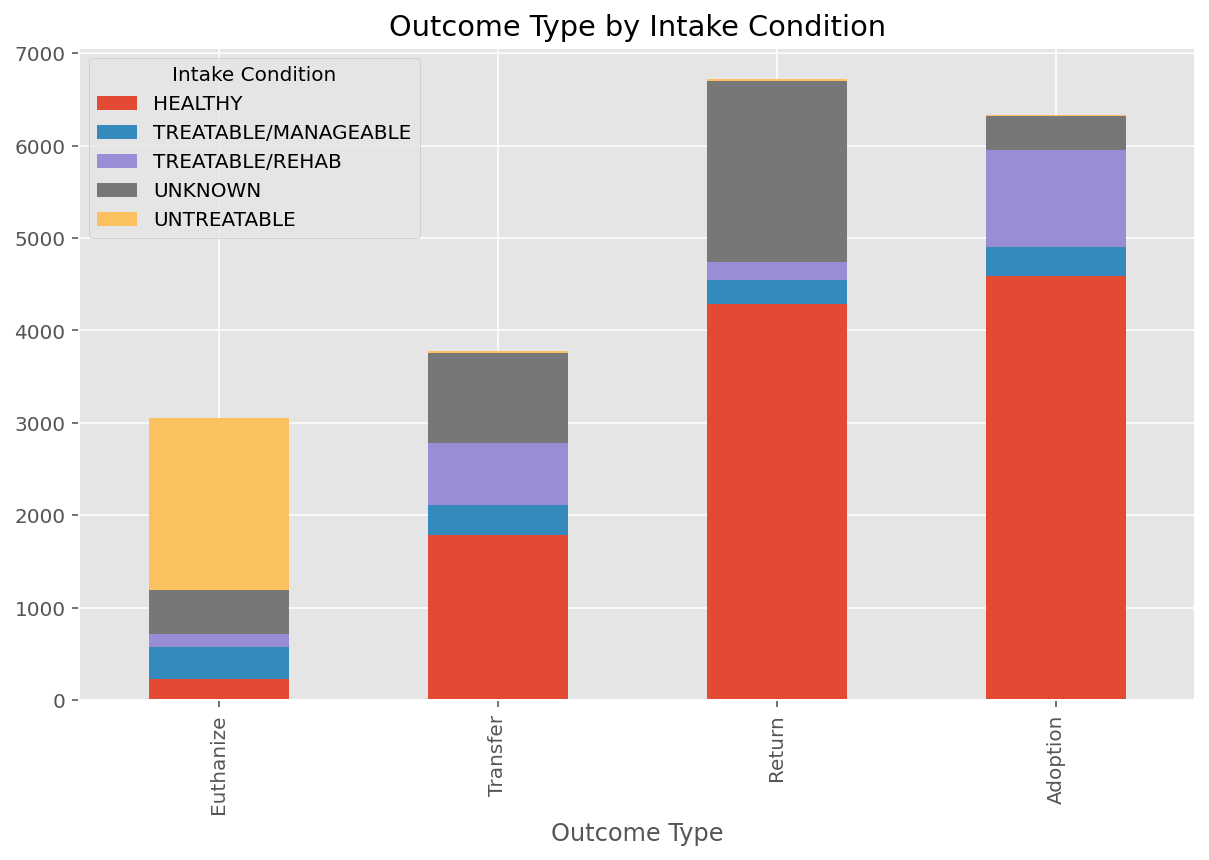

In [19]:
fig, ax = plt.subplots()
df.groupby(['Outcome Type','Intake Condition']).size().unstack().plot(kind='bar',stacked=True, title="Outcome Type by Intake Condition", figsize=(10,6),
                                                            ax=ax)
ax.set_xticklabels(["Euthanize", "Transfer", "Return", "Adoption"])
plt.show()

In [9]:
def create_subdfs(df):
    
    # Separated by Animal Type
    df_cat = df[df['Type'] == 'CAT']
    df_dog = df[df['Type'] == 'DOG']
    df_other = df[df['Type'] == 'OTHER']

    return df_cat, df_dog, df_other

df_cat, df_dog, df_other = create_subdfs(df)

### For this model, `Outcome Type` now consists of 4 classes:
    - 0: euthanize, died
    - 1: transfer (we don't care about this class)
    - 2: return to owner
    - 3: adoption
    
#### Since we'll be predicting "Days in Shelter", the different outcomes will have different rates.
    - However, we will be using a tree based model (random forest, gradient boosting, or xg boost), so this will be accounted for

In [13]:
df['Outcome Type'].unique()
# 0 is "euthanize", 1 is "transfer", 2 is "return to owner", 3 is "adoption"

array([2, 1, 3, 0])

In [17]:
# A lot of different breeds -- how to handle?

len(df.groupby('Type')['Breed'].unique()['CAT'])
#49 cat breeds

len(df.groupby('Type')['Breed'].unique()['DOG'])
#774 dog breeds

len(df.groupby('Type')['Breed'].unique()['OTHER'])
#120 'other' breeds


# Separate mixed breeds into 2 separate breed columns
def separate_breed(df):
    df['Breed'] = df['Breed'].str.replace('/MIX', '')
    new_val = df['Breed'].str.split('/', n=1, expand=True)
    
    df['Breed_1'] = new_val[0]
    df['Breed_2'] = new_val[1]
    
    df = df.drop(columns='Breed', inplace=True)
    
    return df

separate_breed(df)

In [18]:
def separate_color(df):
    new_val = df['Color'].str.split('/', n=1, expand=True)
    
    df['Color_1'] = new_val[0]
    df['Color_2'] = new_val[1]
    
    df = df.drop(columns='Color', inplace=True)
    
    return df

separate_color(df)

In [19]:
# Treatable/Rehab and Treatable/Manageable into a single value -- Treatable

def simplify_intake_condition(df):
    new_val = df['Intake Condition'].str.split('/', n=1, expand=True)
    df['Intake Condition'] = new_val[0]
    
    return df

simplify_intake_condition(df)

,Name,Type,Sex,Size,Impound Number,Kennel Number,Animal ID,Intake Date,Outcome Date,Days in Shelter,Intake Type,Intake Subtype,Outcome Type,Outcome Subtype,Intake Condition,Outcome Condition,Intake Jurisdiction,Outcome Jurisdiction,Outcome Zip Code,Location,Count,Intake_Month,Intake_dayofweek,Intake_Year,Outcome_Month,Outcome_dayofweek,Outcome_Year,Age,Fixed,Has_Name,Breed_1,Breed_2,Color_1,Color_2
0,SKY,DOG,Female,MED,K20-035118,DS69,A395686,2020-01-19,2020-01-23,4,STRAY,FIELD,2,OVER THE COUNTER_CALL,HEALTHY,HEALTHY,COUNTY,COUNTY,95404.0,"95404(38.458384, -122.675588)",1,1,6,2020,1.0,3.0,2020.0,1.96,False,True,GERM SHEPHERD,None,BLACK,TAN
1,COCO,DOG,Male,SMALL,K17-025093,DS83,A379968,2017-08-30,2017-10-04,35,STRAY,FIELD,1,NC AN FRND,UNKNOWN,HEALTHY,SANTA ROSA,OUT OF COUNTY,95758.0,"95758(38.424655, -121.438065)",1,8,2,2017,10.0,2.0,2017.0,2.40,True,True,BEAGLE,None,TRICOLOR,None
2,SUZIE,DOG,Female,LARGE,K15-012348,DA34,A315553,2015-01-07,2015-01-24,17,STRAY,OVER THE COUNTER,3,INTERNET,HEALTHY,HEALTHY,SANTA ROSA,SANTA ROSA,95404.0,"95404(38.458384, -122.675588)",1,1,2,2015,1.0,5.0,2015.0,3.96,True,True,LABRADOR RETR,None,BLACK,None
3,NaN,DOG,Unknown,MED,K20-036188,VET,A398868,2020-07-12,2020-07-12,0,CONFISCATE,FLD_CRUEL,2,MEDICAL,UNKNOWN,HEALTHY,SANTA ROSA,NaN,NaN,NaN,1,7,6,2020,7.0,6.0,2020.0,1.96,False,False,GERM SHEPHERD,None,TRICOLOR,None
4,FELIX,CAT,Male,KITTN,K18-029084,LOBBY,A374683,2018-07-12,2018-08-04,23,STRAY,OVER THE COUNTER,3,WALKIN,HEALTHY,HEALTHY,SANTA ROSA,COUNTY,95407.0,"95407(38.403734, -122.736775)",1,7,3,2018,8.0,5.0,2018.0,0.17,True,True,DOMESTIC SH,None,BLACK,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19964,*ONYX,CAT,Male,SMALL,K16-017789,CS04,A333091,2016-02-13,2016-03-18,34,STRAY,OVER THE COUNTER,3,WALKIN,HEALTHY,HEALTHY,SANTA ROSA,COUNTY,95403.0,"95403(38.486997, -122.749134)",1,2,5,2016,3.0,4.0,2016.0,4.98,True,True,DOMESTIC SH,None,BLACK,None
19965,NaN,DOG,Female,TOY,K15-013157,DS91,A317956,2015-03-14,2015-04-23,40,STRAY,OVER THE COUNTER,0,AGGRESSIVE,TREATABLE,UNTREATABLE,SANTA ROSA,NaN,NaN,NaN,1,3,5,2015,4.0,3.0,2015.0,1.96,False,False,CHIHUAHUA SH,None,TAN,None
19966,TEDDY BEAR,DOG,Male,SMALL,K18-028664,DA20,A374057,2018-06-15,2018-06-15,0,STRAY,FIELD,2,OVER THE COUNTER_WEB,UNKNOWN,HEALTHY,SANTA ROSA,SANTA ROSA,95403.0,"95403(38.486997, -122.749134)",1,6,4,2018,6.0,4.0,2018.0,7.01,True,True,BICHON FRISE,None,CREAM,None
19967,TIPPY,CAT,Female,SMALL,K17-025618,CA03,A362428,2017-10-09,2017-11-05,27,STRAY,FIELD,2,OVER THE COUNTER_PRVS,UNKNOWN,HEALTHY,SANTA ROSA,COUNTY,95403.0,"95403(38.486997, -122.749134)",1,10,0,2017,11.0,6.0,2017.0,7.99,True,True,DOMESTIC SH,None,BLACK,WHITE


## Create dummies for categorial features

In [20]:
def dummify_categ_cols(df):
    
    need_dummies = ['Type', 'Sex', 'Size', 'Intake Condition', 
                'Breed_1', 'Breed_2', 'Color_1', 'Color_2']
    
    # Take care of NaNs before creating dummies
    df['Size'].fillna('Unknown', inplace=True)
    
    for col in need_dummies:
        
        dummies = pd.get_dummies(df[col], prefix=col)
        df = pd.concat([df, dummies], axis=1)
    
    # cols in need_dummies will be dropped in the drop_cols function
    
    return df

df = dummify_categ_cols(df)


## Create sub DF's for each Outcome Type

In [21]:
df_cat, df_dog, df_other = create_subdfs(df)

## Drop columns that are irrelevant and/or `Outcome` related
- Outcome columns will lead to data leakage as they're explanatory columns
- Simplify 'Sex' column into Male, Female, Unknown (currently we have Spayed and Neutered as well)

In [22]:
#We have a new dependent variable -- 'Days in Shelter', combine with drop_col function from part 1 and specify model type

def drop_cols(df, model: str):
    '''
    Input: dataframe, model type = 'clf' or 'reg'
    'clf' model will drop 'Outcome Type' and leave 'Days in Shelter' to be the dependent variable
    'reg' model will drop 'Days in Shelter' and leave 'Outcome Type' to be the dependent variable
    
    Output:
    dataframe with dropped columns
    '''
    
    if model == 'reg':
        
        # Remove 'Outcome Type', keep 'Days in Shelter'
        drop_cols = ['Name', 'Impound Number', 'Kennel Number', 'Outcome Subtype', 
                     'Intake Jurisdiction', 'Outcome Jurisdiction', 'Outcome Jurisdiction', 
                     'Location', 'Count', 'Animal ID', 'Outcome_Year',
                     'Intake Type', 'Intake Subtype', 'Outcome Condition', 
                     'Outcome Date', 'Outcome Zip Code', 'Outcome_Month', 'Outcome_dayofweek',
                    'Outcome Type', 'Type', 'Sex', 'Size', 'Intake Condition', 
                    'Breed_1', 'Breed_2', 'Color_1', 'Color_2'] 
     
        df = df.drop(columns=drop_cols)

        return df
    
    elif model == 'clf':
        
        # Remove 'Days in Shelter', keep 'Outcome Type'
        drop_cols = ['Name', 'Impound Number', 'Kennel Number', 'Outcome Subtype', 
                     'Intake Jurisdiction', 'Outcome Jurisdiction', 'Outcome Jurisdiction', 
                     'Location', 'Count', 'Animal ID', 'Outcome_Year',
                     'Intake Type', 'Intake Subtype', 'Outcome Condition', 
                     'Outcome Date', 'Outcome Zip Code', 'Outcome_Month', 'Outcome_dayofweek',
                    'Days in Shelter', 'Type', 'Sex', 'Size', 'Intake Condition', 
                    'Breed_1', 'Breed_2', 'Color_1', 'Color_2'] 
        
        df = df.drop(columns=drop_cols)

        return df
    
    else:
        print("Enter Model: 'clf' or 'reg'.")

#create dfs for regression model
df_reg = drop_cols(df, 'reg')        
df_cat_reg = drop_cols(df_cat, 'reg')
df_dog_reg = drop_cols(df_dog, 'reg')
df_other_reg = drop_cols(df_other, 'reg')

#create dfs for classification model (part 1)
df_clf = drop_cols(df, 'clf')
df_cat_clf = drop_cols(df_cat, 'clf')
df_dog_clf = drop_cols(df_cat, 'clf')
df_other_clf = drop_cols(df_cat, 'clf')

## Build a Random Forest Regressor
- Calculate the Mean Absolute Error (MAE) and compare with the baseline MAE.
    - Baseline MAE = y_test - mean(y_test)

In [23]:
def run_rf_reg(df, n_estimators=50, criterion='mae'):
    
    # Set up train and test sets
    y = df['Days in Shelter']
    X = df.drop(columns=['Days in Shelter', 'Intake Date'])
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=15)
    
    # Print baseline MAE score
    baseline_errors = abs(y_test - y_test.mean())
    print('Average baseline error: ', round(np.mean(baseline_errors), 2))
    
    # Set up RF Regressor and run
    regr = RandomForestRegressor(n_estimators=n_estimators, criterion=criterion,
                            n_jobs=-1, verbose=2, random_state=13)
    # Train and predict
    regr.fit(X_train, y_train)
    pred = regr.predict(X_test)
    
    # Print metrics
    print('Mean Absolute Error (MAE):', mean_absolute_error(y_test, pred))
    print('Mean Squared Error (MSE):', mean_squared_error(y_test, pred))
    print('Root Mean Squared Error (RMSE):', np.sqrt(mean_squared_error(y_test, pred)))
    
    # Plot feature importances
    feat_scores = pd.DataFrame({'Fraction of Samples Affected' : regr.feature_importances_},
                           index=X.columns)
    feat_scores = feat_scores.sort_values(by='Fraction of Samples Affected', ascending=False)
    feat_scores[:30].plot(kind='barh', figsize=(10,10))
    plt.show()

In [24]:
# Everything combined - animal type, outcome type

# run_rf_reg(df)

# Baseline MSE: 16.33
# RF MAE: 12.14 --- 23% decrease

# Top 5 features: Age, Intake month/year/day of week, Fixed, Intake Condition, Has name

## How will the model perform if we separate the data into:
- Different Outcome Types
    - Good (adoption), neutral (transfer, return), or bad (euthanize, dead)
- Different Animal Types
    - Cats, Dogs, or Other (pigs, birds, donkeys, etc

In [25]:
# Predict 'Days in Shelter' given that the outcome is adoption

# run_rf_reg(df_good)

# Baseline MAE: 21.23
# RF MAE: 16.68 --- 21.4% decrease

# Top 5 features: Age, Intake date, Intake condition, Pitbull, Border Collie, Black

In [26]:
# Predict 'Days in Shelter' given that the outcome is either Transfer or Return to Owner

# run_rf_reg(df_neut)

# Baseline MAE: 10.76
# RF MAE: 8.48 -- 21.1% decrease

# Top 5 features: Age, Intake date, Type Other, Fixed, Dachshund

In [27]:
# Predict 'Days in Shelter' given that the outcome is Euthanize, Dead, or Escaped

# run_rf_reg(df_bad)

# Baseline MAE: 13.93
# RF MAE: 8.50 -- 40.0% decrease

# Top 5 features: Type Dog, Age, Intake Date, Has Name, Red

In [28]:
# Predict 'Days in Shelter' for Cats only

# run_rf_reg(df_cat)

# Baseline MAE: 15.06
# RF MAE: 8.65 -- 42.6% decrease
# Top 5 features: Age, Has Name, Intake Date, Fixed, Intake Condition

In [29]:
# Predict 'Days in Shelter' for Dogs only

# run_rf_reg(df_dog)

# Baseline MAE: 16.29
# RF MAE: 14.39 -- 11.7% decrease

# Top 5 features: Age, Intake date, Intake condition, fixed, white, tan

In [30]:
# Predict 'Days in Shelter' for 'other' animals - pigs, goats, birds, sheep, etc

# run_rf_reg(df_other)

# Baseline MAE: 20.97
# RF MAE: 9.91 -- 52.7% decrease

# Top 5 features: Intake date, age, sex, intake condition, fixed, Koi

In [31]:
# Save datasets that can be plugged into models

# df.to_csv('data_cleaned.csv')
# df_good.to_csv('data_cleaned_adopted.csv')
# df_neut.to_csv('data_cleaned_transfer_return.csv')
# df_bad.to_csv('data_cleaned_euthanize_dead.csv')
# df_cat.to_csv('cats_data_cleaned.csv')
# df_dog.to_csv('dogs_data_cleaned.csv')
# df_other.to_csv('other_animals_data_cleaned.csv')

In [32]:
df_reg.to_csv('../data/reg_data_cleaned.csv')
df_cat_reg.to_csv('../data/reg_cat_data.csv')
df_dog_reg.to_csv('../data/reg_dog_data.csv')
df_other_reg.to_csv('../data/reg_other_data.csv')

df_clf.to_csv('../data/clf_data_cleaned.csv')
df_cat_clf.to_csv('../data/clf_cat_data.csv')
df_dog_clf.to_csv('../data/clf_dog_data.csv')
df_other_clf.to_csv('../data/clf_other_data.csv')

## I will be trying other models and optimizations in `Run_Models_Parts_1_and_2` 